Für die bessere Überischt importieren wir alles an einem Ort. Wir verwenden hier Keras V3, was theoretisch mit mehreren backend funktionieren könnte. Bei uns gab es aber Probleme bei dem Trainieren der Modelle mit Torch. Deshalb verwenden wir Tensorflow, leider ohne GPU Support auf Windows

In [7]:
import os
# os.environ["KERAS_BACKEND"] = "torch"
import keras
from keras import layers
from matplotlib import pyplot as plt
from tensorflow import data as tf_data

IMAGE_SIZE = (128, 128)
INPUT_SHAPE = (128, 128, 3)
BATCH_SIZE = 64



Mit der Funktion `image_dataset_from_directory` können wir die Bilddaten von der Festplatte laden. Dabei müssen sie in einem bestimmten Format sein. Ein Image Ordner mit jeweils einem Ordner für jede Klasse. Hier werden auch direkt die Batches erstellt, die Bilder gepadded auf eine gemeinsame Grösse und ein Validation/Trian Split erstellt.

In [8]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
        os.path.join("data", "images"),
        labels="inferred",
        label_mode="categorical",
        color_mode="rgb",
        batch_size=BATCH_SIZE,
        image_size=IMAGE_SIZE,
        shuffle=True,
        interpolation="bilinear",
        crop_to_aspect_ratio=True,
        validation_split=0.2,
        subset="both",
        seed=42,
    )

NUMBER_OF_CLASSES = len(train_ds.class_names)
train_ds, val_ds

Found 9100 files belonging to 7 classes.
Using 7280 files for training.
Using 1820 files for validation.


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>)

Data Augmentation sollte theoretisch dabei helfen die Klassifikation besser zu machen, indem die Daten variiert werden. Wir drehen sie und verändern den Kontrast und die Helligkeit. Zusätzlich werden die Daten normalisiert. 

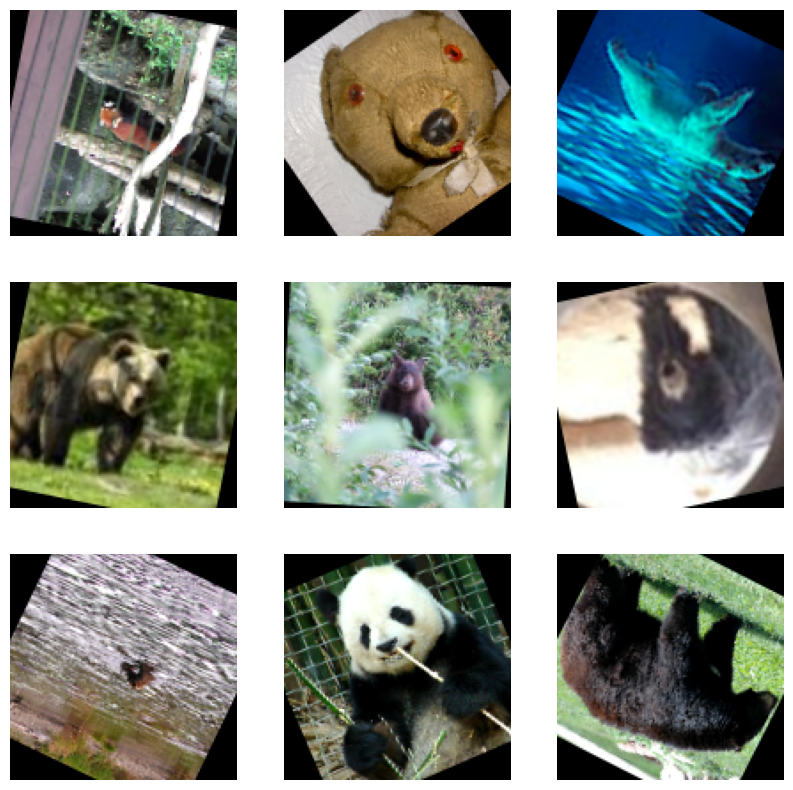

In [9]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1, fill_mode="constant", interpolation="bilinear"),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1),
    layers.Rescaling(1./255)
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

augmented_train_ds = train_ds.map(
    lambda images, labels: (data_augmentation(images), labels),
    num_parallel_calls=tf_data.AUTOTUNE)

augmented_val_ds = val_ds.map(
    lambda images, labels: (data_augmentation(images), labels),
    num_parallel_calls=tf_data.AUTOTUNE)

plt.figure(figsize=(10, 10))
for batch_images, _ in augmented_train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(keras.utils.array_to_img(batch_images[i]))
        plt.axis("off")

Die Daten vorab in das Memory zu laden ist theoretisch schneller, deshalb machen wir es

In [10]:
augmented_train_ds = augmented_train_ds.prefetch(tf_data.AUTOTUNE)
augmented_val_ds = augmented_val_ds.prefetch(tf_data.AUTOTUNE)

Dann bauen wir ein einfaches CNN. Durch Keras util Funktionen können wir zusätzlich das Modell graphisch anzeigen lassen.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 59, 59, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 10, 10, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │        44,807 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 734,951 (2.80 MB)

 Trainable params: 734,951 (2.80 MB)

 Non-trainable params: 0 (0.00 B)

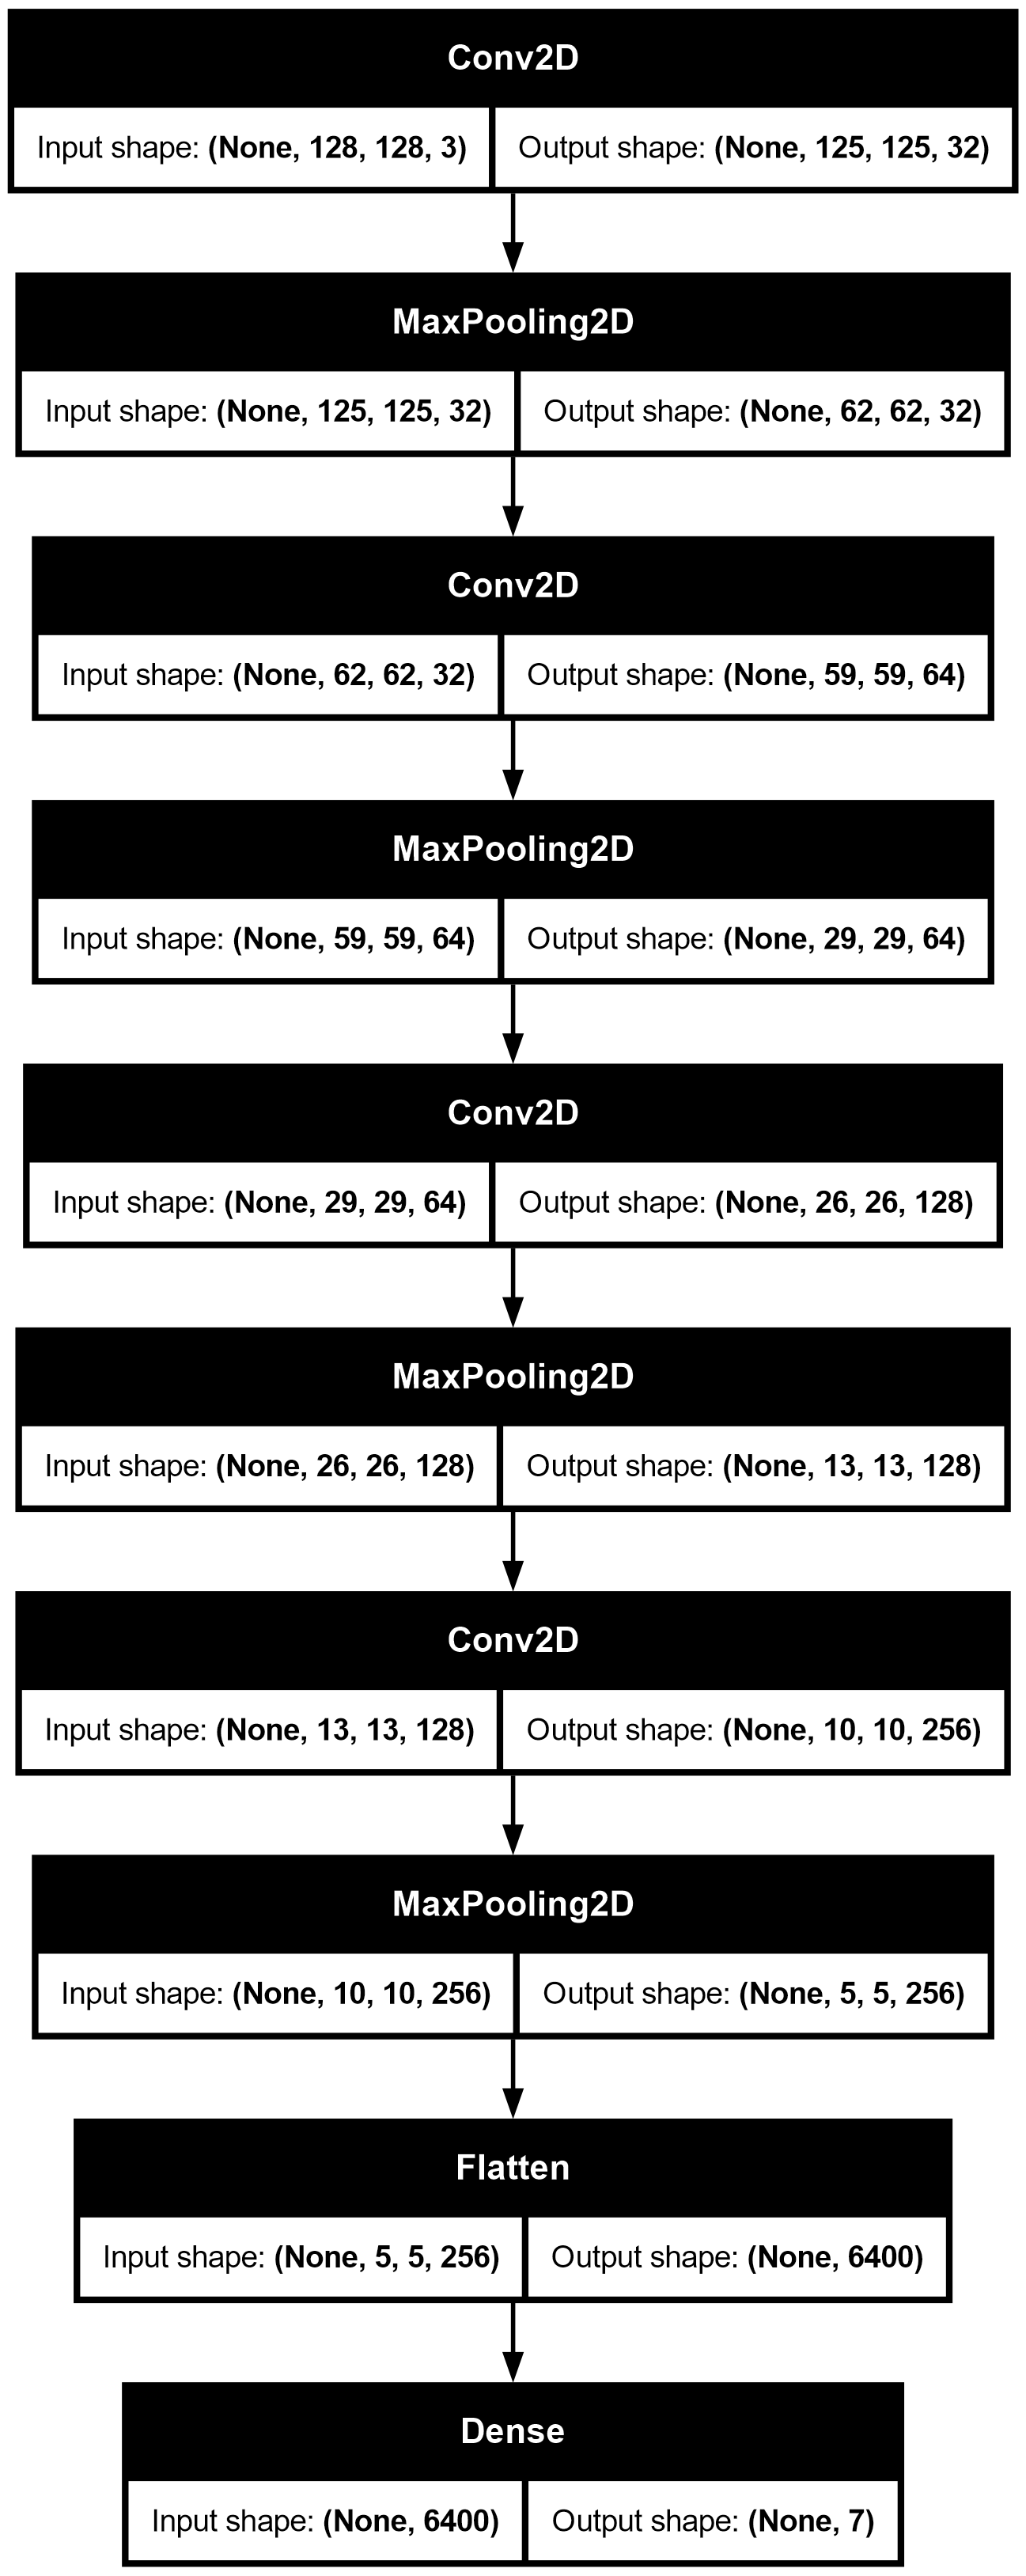

In [11]:
model = keras.Sequential([
    layers.InputLayer(shape=INPUT_SHAPE),
    layers.Conv2D(32, (4, 4), activation="relu"),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(64, (4, 4), activation="relu"),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(128, (4, 4), activation="relu"),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(256, (4, 4), activation="relu"),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(NUMBER_OF_CLASSES, activation='softmax'),
])
model.compile(
  'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)
model.summary()
keras.utils.plot_model(model, show_shapes=True)

Training mit Live-Plots

In [12]:
from livelossplot import PlotLossesKeras

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[PlotLossesKeras()],
)

accuracy
	training         	 (min:    0.384, max:    0.384, cur:    0.384)
	validation       	 (min:    0.521, max:    0.521, cur:    0.521)
Loss
	training         	 (min:    3.791, max:    3.791, cur:    3.791)
	validation       	 (min:    1.282, max:    1.282, cur:    1.282)
114/114 ━━━━━━━━━━━━━━━━━━━━ 26s 220ms/step - accuracy: 0.2676 - loss: 10.6029 - val_accuracy: 0.5209 - val_loss: 1.2823
Epoch 2/5
  7/114 ━━━━━━━━━━━━━━━━━━━━ 22s 208ms/step - accuracy: 0.5121 - loss: 1.3105

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x0000014BF2BAA750>>
Traceback (most recent call last):
  File "M:\apps\anaconda\envs\test123\Lib\site-packages\ipykernel\ipkernel.py", line 790, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "M:\apps\anaconda\envs\test123\Lib\site-packages\ipykernel\ipkernel.py", line 790, in <setcomp>
    active_threads = {thread.ident for thread in threading.enumerate()}
                      ^^^^^^^^^^^^
  File "M:\apps\anaconda\envs\test123\Lib\threading.py", line 1168, in ident
    @property

KeyboardInterrupt: 


KeyboardInterrupt: 